In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

print("=" * 80)
print("LOADING EXTRACTED FEATURES FOR TRAINING")
print("=" * 80)

LOADING EXTRACTED FEATURES FOR TRAINING


In [2]:
# Load the extracted features and labels
OUTPUT_DIR = Path(r'c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output')
X_data = np.load(OUTPUT_DIR / 'features' / 'X_features.npy')
y_data = np.load(OUTPUT_DIR / 'features' / 'y_labels.npy')
# y_data = np.load('y_labels.npy')
label_encoder_classes = np.load(OUTPUT_DIR / 'features' / 'label_encoder_classes.npy')
# label_encoder_classes = np.load('label_encoder_classes.npy')

print(f"Features shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")

# Encode labels
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes
y_encoded = label_encoder.fit_transform(y_data)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Features shape: (1000, 30, 63)
Labels shape: (1000,)
Training samples: 800
Validation samples: 200


## Dataset Class Definition

In [3]:
class SignLanguageDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets and dataloaders
train_dataset = SignLanguageDataset(X_train, y_train)
val_dataset = SignLanguageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("✓ Datasets and DataLoaders created")

✓ Datasets and DataLoaders created


## Model Architecture: ResNetLSTM

In [4]:
class ResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=2):
        super(ResNetLSTM, self).__init__()
        
        # Feature extractor for hand landmarks (63 features)
        self.feature_extractor = nn.Sequential(
            nn.Linear(63, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)
        )
        
        # Bidirectional LSTM for temporal modeling
        self.lstm = nn.LSTM(256, hidden_size, num_layers, 
                           batch_first=True, dropout=0.3, bidirectional=True)
        
        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        
        # Extract features from each frame
        x = x.view(batch_size * seq_len, features)
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)
        
        # Process sequence with LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Use last hidden state
        
        # Classify
        x = self.fc(x)
        return x

print("✓ Model architecture defined")

✓ Model architecture defined


## Model Initialization and Training Setup

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
num_classes = len(label_encoder.classes_)
model = ResNetLSTM(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print(f"Model initialized with {num_classes} classes")

Using device: cuda
Model initialized with 20 classes
Model initialized with 20 classes


## Training Loop

In [6]:
print("\n" + "=" * 80)
print("TRAINING MODEL")
print("=" * 80)

num_epochs = 200
best_accuracy = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    scheduler.step(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Accuracy: {accuracy:.2f}%")
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
            'num_classes': num_classes
        }, 'best_sign_language_model_200.pth')
        print(f"✓ Model saved with accuracy: {accuracy:.2f}%")

print("\n" + "=" * 80)
print(f"TRAINING COMPLETED - Best Accuracy: {best_accuracy:.2f}%")
print("=" * 80)


TRAINING MODEL
Epoch [1/200] | Loss: 2.9158 | Val Accuracy: 9.00%
✓ Model saved with accuracy: 9.00%
Epoch [1/200] | Loss: 2.9158 | Val Accuracy: 9.00%
✓ Model saved with accuracy: 9.00%
Epoch [2/200] | Loss: 2.6630 | Val Accuracy: 12.50%
✓ Model saved with accuracy: 12.50%
Epoch [2/200] | Loss: 2.6630 | Val Accuracy: 12.50%
✓ Model saved with accuracy: 12.50%
Epoch [3/200] | Loss: 2.4644 | Val Accuracy: 24.00%
✓ Model saved with accuracy: 24.00%
Epoch [3/200] | Loss: 2.4644 | Val Accuracy: 24.00%
✓ Model saved with accuracy: 24.00%
Epoch [4/200] | Loss: 2.2174 | Val Accuracy: 29.00%
✓ Model saved with accuracy: 29.00%
Epoch [4/200] | Loss: 2.2174 | Val Accuracy: 29.00%
✓ Model saved with accuracy: 29.00%
Epoch [5/200] | Loss: 2.0622 | Val Accuracy: 37.00%
✓ Model saved with accuracy: 37.00%
Epoch [5/200] | Loss: 2.0622 | Val Accuracy: 37.00%
✓ Model saved with accuracy: 37.00%
Epoch [6/200] | Loss: 1.8307 | Val Accuracy: 41.50%
✓ Model saved with accuracy: 41.50%
Epoch [6/200] | Loss

## Training Visualization

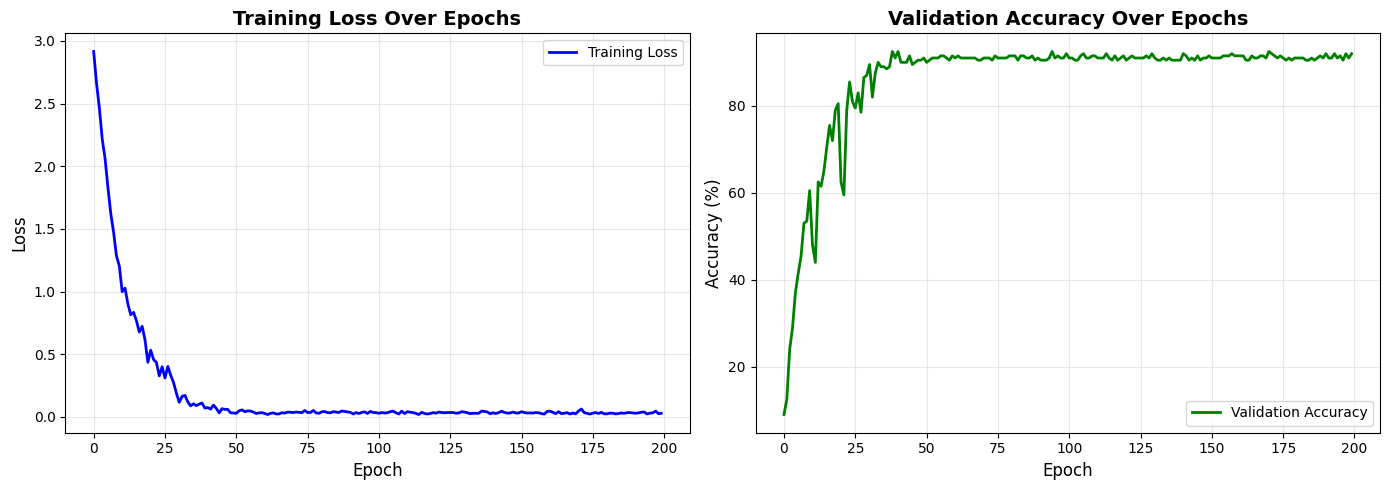


Training completed successfully!
Files created:
  - best_sign_language_model.pth
  - training_metrics.png


In [7]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining completed successfully!")
print("Files created:")
print("  - best_sign_language_model.pth")
print("  - training_metrics.png")